<a href="https://colab.research.google.com/github/Manikanta123A/Price-Prediction-/blob/main/PricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 62.3 MB/s eta 0:00:00


In [1]:
import gdown
import pandas as pd

file_id = "1U4XEQKSXEFmD1kN9V1_pbKCVCMSGktJD"
url = f"https://drive.google.com/uc?id={file_id}"

df = pd.read_csv(url)

df_first_two = df.iloc[:5000,[0,1,3]]


print(df_first_two.head())


   sample_id                                    catalog_content  price
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   4.89
1     198967  Item Name: Salerno Cookies, The Original Butte...  13.12
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   1.97
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...  30.34
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...  66.49


In [2]:
missing_values = df_first_two.isnull().sum()
print("Missing values in Data:\n", missing_values)


# 1.3 Analyze data types and preview catalog_content
print("Data types:\n", df_first_two.dtypes)
print(df_first_two['catalog_content'].head())

# 1.4 Statistical info on catalog_content length
df_first_two['text_length'] = df_first_two['catalog_content'].apply(lambda x: len(str(x)))

print("DataSet catalog_content length stats:", df_first_two['text_length'].describe())


Missing values in Data:
 sample_id          0
catalog_content    0
price              0
dtype: int64
Data types:
 sample_id            int64
catalog_content     object
price              float64
dtype: object
0    Item Name: La Victoria Green Taco Sauce Mild, ...
1    Item Name: Salerno Cookies, The Original Butte...
2    Item Name: Bear Creek Hearty Soup Bowl, Creamy...
3    Item Name: Judee’s Blue Cheese Powder 11.25 oz...
4    Item Name: kedem Sherry Cooking Wine, 12.7 Oun...
Name: catalog_content, dtype: object
DataSet catalog_content length stats: count    5000.000000
mean      897.024200
std       860.598395
min        37.000000
25%       238.000000
50%       628.500000
75%      1250.250000
max      6192.000000
Name: text_length, dtype: float64


In [3]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)


In [7]:

df_cleaned = df_first_two.copy()
df_cleaned[df_cleaned.columns[1]] = df_cleaned.iloc[:, 1].apply(clean_text)
print(df_cleaned.head())

   sample_id                                    catalog_content  price  \
0      33127  item name: la victoria green taco sauce mild, ...   4.89   
1     198967  item name: salerno cookies, original butter co...  13.12   
2     261251  item name: bear creek hearty soup bowl, creamy...   1.97   
3      55858  item name: judee’s blue cheese powder 11.25 oz...  30.34   
4     292686  item name: kedem sherry cooking wine, 12.7 oun...  66.49   

   text_length  
0           91  
1          511  
2          328  
3         1318  
4          155  


In [8]:
import pandas as pd
import numpy as np
import re

def parse_catalog(content):

    if not isinstance(content, str):
        content = ''

    item_name, product_name, product_qualities, product_description = None, None, None, None
    pack_count, quantity, unit, single_item_quantity = None, None, None, np.nan


    item_name_match = re.search(r"Item Name:\s*(.*?)(?:\n|$)", content, re.IGNORECASE)
    if item_name_match:
        item_name = item_name_match.group(1).strip()


    bullet_points = re.findall(r"Bullet Point(?: \d+)?:\s*(.*)", content, re.IGNORECASE)
    product_qualities = '; '.join([bp.strip() for bp in bullet_points]) if bullet_points else None


    description_match = re.search(r"Product Description:\s*(.*)", content, re.IGNORECASE | re.DOTALL)
    product_description = description_match.group(1).strip() if description_match else None

    quantity_match = re.search(r"Value:\s*([\d\.]+)", content, re.IGNORECASE)
    quantity = float(quantity_match.group(1)) if quantity_match else None

    unit_match = re.search(r"Unit:\s*(\w+)", content, re.IGNORECASE)
    unit = unit_match.group(1).strip() if unit_match else None


    if item_name:
        pack_count_match = re.search(r"\(Pack of (\d+)\)", item_name, re.IGNORECASE)
        if not pack_count_match:
            pack_count_match = re.search(r"Pack of\s*(\d+)", item_name, re.IGNORECASE)
        pack_count = int(pack_count_match.group(1)) if pack_count_match else None


        product_name = re.sub(r'\s*\(?Pack of \d+\)?', '', item_name, flags=re.IGNORECASE).strip()


        s_quant_match = re.search(r'(\d+(\.\d+)?)\s*(Ounce|Oz|Fl Oz|g|kg|lb|pound|count|ct)', item_name, re.IGNORECASE)
        if s_quant_match:
            single_item_quantity = float(s_quant_match.group(1))


    return pd.Series({
        'item_name': item_name,
        'product_name': product_name,
        'pack_count': pack_count,
        'quantity': quantity,
        'unit': unit,
        'single_item_quantity': single_item_quantity, # Added new feature
        'product_qualities': product_qualities,
        'product_description': product_description
    })

In [9]:
print("Step 1: Applying the parsing function to each row...")
parsed_data = df_cleaned['catalog_content'].apply(parse_catalog)

print("Step 2: Assembling the final DataFrame...")

df_final = df_cleaned[['sample_id']].join(parsed_data)

final_columns = [
    'sample_id',
    'item_name',
    'product_name',
    'pack_count',
    'quantity',
    'unit',
    'product_qualities',
    'product_description',

]

df_final = df_final[final_columns]

Step 1: Applying the parsing function to each row...
Step 2: Assembling the final DataFrame...


In [10]:
print("Step 3: Displaying the results...")
print("\n--- Final DataFrame Structure and Data Types ---")

df_final.info()

Step 3: Displaying the results...

--- Final DataFrame Structure and Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sample_id            5000 non-null   int64  
 1   item_name            5000 non-null   object 
 2   product_name         5000 non-null   object 
 3   pack_count           10 non-null     float64
 4   quantity             4926 non-null   float64
 5   unit                 4998 non-null   object 
 6   product_qualities    4012 non-null   object 
 7   product_description  2134 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 312.6+ KB


In [11]:
df_final.head()

,sample_id,item_name,product_name,pack_count,quantity,unit,product_qualities,product_description
0,33127,"la victoria green taco sauce mild, 12 ounce (p...","la victoria green taco sauce mild, 12 ounce (p...",NaN,72.00,fl,None,None
1,198967,"salerno cookies, original butter cookies, 8 ou...","salerno cookies, original butter cookies, 8 ou...",NaN,32.00,ounce,original butter cookies: classic butter cooky ...,None
2,261251,"bear creek hearty soup bowl, creamy chicken ri...","bear creek hearty soup bowl, creamy chicken ri...",NaN,11.40,ounce,loaded hearty long grain wild rice vegetable b...,None
3,55858,judee’s blue cheese powder 11.25 oz - gluten-f...,judee’s blue cheese powder 11.25 oz - gluten-f...,NaN,11.25,ounce,"add favorite appetizers, dip & spreads. use se...",judees powdered blue cheese cheddar cheese pow...
4,292686,"kedem sherry cooking wine, 12.7 ounce - 12 per...","kedem sherry cooking wine, 12.7 ounce - 12 per...",NaN,12.00,count,"kedem sherry cooking wine, 12.7 ounce - 12 per...",None


In [12]:
df_final['unit'].unique()

array(['fl', 'ounce', 'count', 'none', 'fluid', 'oz', 'pound', 'gram',
       'lb', None, 'liter', 'gramm', 'ct', 'millilitre', 'jar', 'bottle'],
      dtype=object)

In [13]:

unit_mapping = {

    'ounce': 'ounce', 'ounces': 'ounce', 'oz': 'ounce',
    'pound': 'pound', 'pounds': 'pound', 'lb': 'pound',
    'gram': 'gram', 'grams': 'gram', 'gr': 'gram', 'gramm': 'gram',
    'kg': 'kilogram',


    'fl': 'fluid_ounce', 'fluid': 'fluid_ounce',
    'millilitre': 'milliliter', 'mililitro': 'milliliter', 'ml': 'milliliter',
    'liters': 'liter', 'ltr': 'liter',


    'count': 'count', 'ct': 'count', 'each': 'count',
    'pack': 'count', 'packs': 'count', 'piece': 'count',
    'units': 'count', 'case': 'count', 'box': 'count',
    'jar': 'count', 'bottle': 'count', 'bottles': 'count',
    'can': 'count', 'bag': 'count', 'pouch': 'count',
    'bucket': 'count', 'carton': 'count', 'capsule': 'count',

    'none': 'missing'
}

In [14]:
df_final['unit'] = df_final['unit'].astype(str).str.lower().str.strip()
df_final['unit'] = df_final['unit'].replace(unit_mapping)
clean_units = ['ounce', 'pound', 'gram', 'kilogram', 'fluid_ounce',
               'milliliter', 'liter', 'count', 'missing']

df_final.loc[~df_final['unit'].isin(clean_units), 'unit'] = 'other'

In [15]:
df_final.head()

,sample_id,item_name,product_name,pack_count,quantity,unit,product_qualities,product_description
0,33127,"la victoria green taco sauce mild, 12 ounce (p...","la victoria green taco sauce mild, 12 ounce (p...",NaN,72.00,fluid_ounce,None,None
1,198967,"salerno cookies, original butter cookies, 8 ou...","salerno cookies, original butter cookies, 8 ou...",NaN,32.00,ounce,original butter cookies: classic butter cooky ...,None
2,261251,"bear creek hearty soup bowl, creamy chicken ri...","bear creek hearty soup bowl, creamy chicken ri...",NaN,11.40,ounce,loaded hearty long grain wild rice vegetable b...,None
3,55858,judee’s blue cheese powder 11.25 oz - gluten-f...,judee’s blue cheese powder 11.25 oz - gluten-f...,NaN,11.25,ounce,"add favorite appetizers, dip & spreads. use se...",judees powdered blue cheese cheddar cheese pow...
4,292686,"kedem sherry cooking wine, 12.7 ounce - 12 per...","kedem sherry cooking wine, 12.7 ounce - 12 per...",NaN,12.00,count,"kedem sherry cooking wine, 12.7 ounce - 12 per...",None


In [16]:
#filling the pack_count values with 1
df_final['pack_count'] = df_final['pack_count'].fillna(1)

In [17]:
print(f"NaNs in pack_count after fill: {df_final['pack_count'].isnull().sum()}")


NaNs in pack_count after fill: 0


In [18]:
#Filling the Quantity with its Median Value

quantity_median = df_final['quantity'].median()


print(f"Calculated Quantity Median: {quantity_median}")

print("---")
print(f"NaNs in quantity BEFORE median fill: {df_final['quantity'].isnull().sum()}")


df_final['quantity'] = df_final['quantity'].fillna(quantity_median)


print("---")
print(f"NaNs in quantity AFTER median fill: {df_final['quantity'].isnull().sum()}")


Calculated Quantity Median: 16.0
---
NaNs in quantity BEFORE median fill: 74
---
NaNs in quantity AFTER median fill: 0


In [23]:
df_final[ 'product_description'] = df_final[ 'product_description'].fillna(df_final['item_name'])
df_final[ 'product_description'].isnull().sum()

np.int64(0)

In [24]:
df_final[  'product_qualities'] = df_final[  'product_qualities'].fillna(df_final['product_name'])
df_final[  'product_qualities'].isnull().sum()

np.int64(0)

In [25]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sample_id            5000 non-null   int64  
 1   item_name            5000 non-null   object 
 2   product_name         5000 non-null   object 
 3   pack_count           5000 non-null   float64
 4   quantity             5000 non-null   float64
 5   unit                 5000 non-null   object 
 6   product_qualities    5000 non-null   object 
 7   product_description  5000 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 312.6+ KB


In [19]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
w2v_model = Word2Vec.load("/content/word2vec_model.model")

In [29]:
text_cols = ['item_name',
    'product_name',
    'product_qualities',
    'product_description',]

def avg_w2v(sentence_list, model):
    vecs = []
    for word in sentence_list:
        if word in model.wv:
            vecs.append(model.wv[word])
    if len(vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

text_embeddings = []
for col in text_cols:
    emb_col = np.vstack(df_final[col].apply(lambda x: avg_w2v(x, w2v_model)))
    text_embeddings.append(emb_col)

In [54]:
text_cols = ['catalog_content']

def avg_w2v(sentence_list, model):
    vecs = []
    for word in sentence_list:
        if word in model.wv:
            vecs.append(model.wv[word])
    if len(vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

text_embeddings = []
for col in text_cols:
    emb_col = np.vstack(df_cleaned[col].apply(lambda x: avg_w2v(x, w2v_model)))
    text_embeddings.append(emb_col)

In [43]:
from gensim.models import Word2Vec
import numpy as np

texts = df_cleaned['catalog_content'].tolist()


tokenized_texts = [text.split() for text in texts]


embeddings_list = []
for tokens in tokenized_texts:
    word_vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(word_vectors) > 0:
        sentence_embedding = np.mean(word_vectors, axis=0)
    else:
        sentence_embedding = np.zeros(w2v_model.vector_size)
    embeddings_list.append(sentence_embedding)

In [53]:
df_cleaned.head()

,sample_id,catalog_content,price,text_length
0,33127,"item name: la victoria green taco sauce mild, ...",4.89,91
1,198967,"item name: salerno cookies, original butter co...",13.12,511
2,261251,"item name: bear creek hearty soup bowl, creamy...",1.97,328
3,55858,item name: judee’s blue cheese powder 11.25 oz...,30.34,1318
4,292686,"item name: kedem sherry cooking wine, 12.7 oun...",66.49,155


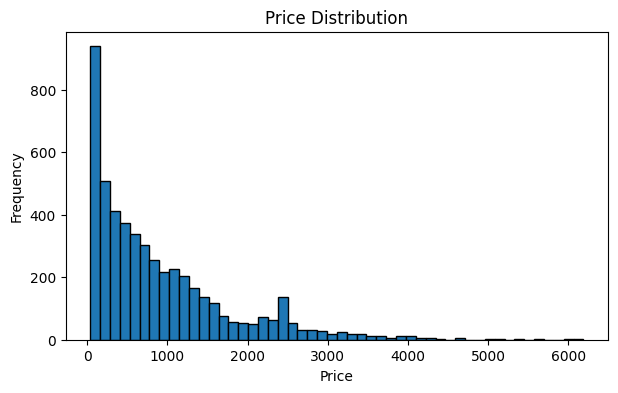

In [68]:
import matplotlib.pyplot as plt


price = df_cleaned.iloc[:5000, 3]

plt.figure(figsize=(7,4))
plt.hist(price, bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [61]:
df['price'] = np.log1p(df['price'])


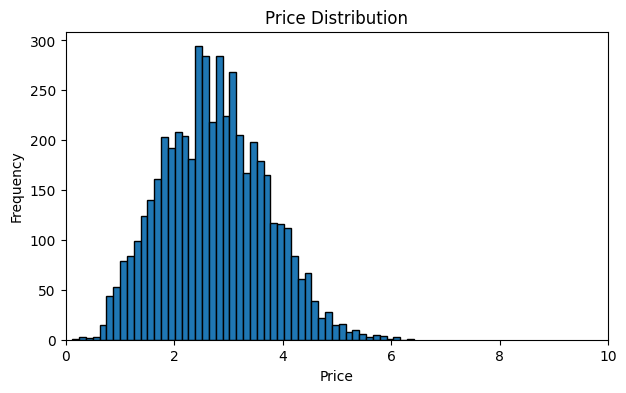

In [69]:
import matplotlib.pyplot as plt


price = df.iloc[:5000, 3]

plt.figure(figsize=(7,4))
plt.hist(price, bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 10)
plt.show()


In [62]:
num_cols = [    'pack_count',
    'quantity',
   ]
scaler = StandardScaler()
num_data = scaler.fit_transform(df_final[num_cols])


X = np.hstack(text_embeddings + [num_data])
y = df.iloc[:5000,3].values


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(512, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1, activation='linear')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=128, callbacks=[es], verbose=1)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.0730 - mae: 1.3740 - val_loss: 0.9520 - val_mae: 0.7807
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0906 - mae: 0.8357 - val_loss: 0.8651 - val_mae: 0.7457
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0510 - mae: 0.8190 - val_loss: 0.8279 - val_mae: 0.7290
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9949 - mae: 0.8061 - val_loss: 0.8995 - val_mae: 0.7551
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9400 - mae: 0.7821 - val_loss: 0.8428 - val_mae: 0.7322
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9973 - mae: 0.8002 - val_loss: 0.8726 - val_mae: 0.7428
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9676 - mae: 0.7885 - val_loss: 0.8054 - val_mae: 0.7180
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9447 - mae: 0.7708 - val_loss: 0.8103 - val_mae: 0.7182
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

In [42]:
y_pred = model.predict(X_val)
print("Sample predictions:", y_pred[:10])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Sample predictions: [[0.80463207]
 [0.8135543 ]
 [0.7707032 ]
 [0.800761  ]
 [0.8085525 ]
 [0.79723144]
 [0.833251  ]
 [0.7919702 ]
 [0.8294922 ]
 [0.7749464 ]]
